In [1]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.optimizers import Adam
from tqdm import trange

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:

GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 1000000
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [4]:
state_space=1
obs_space=1
action_space=3
intermediate_dim=16

In [5]:
from mountain_car import MountainCarEnv
env=MountainCarEnv()


In [6]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,state_space)))
        model.add(Dense(512,activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        return model

In [7]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.99975, 
                  memory_size = 10_000,  C = 5):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel((1,self.states), self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=EXPLORATION_DECAY
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
           #print(X.shape,"   ",y.shape  )                          
            #loss = self.model.Qpolicy.fit(final_dataset,verbose=0)   
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
           # print(self.model.Qpolicy.predict_on_batch(X))
           #print(X.shape,"   ",y.shape  )                          
            loss = self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [8]:
def get_obs(state):
    return [state[1]]

In [9]:
dqn_solver=DQNSolver(state_space=obs_space,action_space=action_space)


In [10]:
def data_collection(total_episodes,dqn_solver):


    O_series=[]
    U_series=[]
    R_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0]]))


    ep_no=0
    i=0
    while(ep_no<total_episodes):
        o=env.reset()
        o=o[0]

        #s0=np.reshape(s0,[1,state_space])
        o=get_obs(o)
        step=0
        done=False
        for t in range(200):
            
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                
           
            o=np.reshape(o,(1,obs_space))
            O_series.append(o)
            action=dqn_solver.act(o)

            obs, reward, done, info ,_= env.step(int(action))
            obs=get_obs(obs)
            Done_series.append(done)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])

            
            R_series.append(reward)
            o=obs
            # print(s.shape)
            # print(action.shape)

            step+=1
            if done:
                break
        ep_no+=1
    return O_series,U_series,R_series,Done_series


In [11]:
def dqn_training(dqn_solver,epochs,O_series,U_series,R_series,Done_series):
    #dqn_solver.forget()
    for i in range(len(O_series)-1):
        dqn_solver.remember(O_series[i][0],U_series[i][0][0],R_series[i],O_series[i+1][0],Done_series[i])
    for j in trange(epochs):
        dqn_solver.train()
        if(j%5==0):
            dqn_solver.update_target_model()

In [12]:
rewards_storage=[]

In [13]:
def complete_loop(dqn_solver,epochs):
    for epoch in range(epochs):
        O_series,U_series,R_series,Done_series=data_collection(100,dqn_solver)
        print("epoch: {}, total reward: {}".format(epoch, sum(R_series)))
        print(dqn_solver.model.Qpolicy.weights[0][0][0])
        rewards_storage.append(sum(R_series))
        
        dqn_training(dqn_solver,500,O_series,U_series,R_series,Done_series)#50,500
        dqn_solver.decrement_epsilon()
            


In [14]:
complete_loop(dqn_solver,200)

epoch: 0, total reward: 1923.9530909557172
tf.Tensor(-0.056607485, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.17it/s]


epoch: 1, total reward: 1918.537981138895
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.22it/s]


epoch: 2, total reward: 1923.326432141421
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.31it/s]


epoch: 3, total reward: 1921.4426313881154
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.02it/s]


epoch: 4, total reward: 1916.873430619638
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.08it/s]


epoch: 5, total reward: 1913.7919612788555
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.18it/s]


epoch: 6, total reward: 1919.9928098839366
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 23.92it/s]


epoch: 7, total reward: 1927.4379643301902
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.23it/s]


epoch: 8, total reward: 1921.5554567995987
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 23.98it/s]


epoch: 9, total reward: 1924.2816745852
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.13it/s]


epoch: 10, total reward: 1929.285410772431
tf.Tensor(-0.05462844, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.19it/s]


epoch: 11, total reward: 1924.8781394168072
tf.Tensor(-0.05782571, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


epoch: 12, total reward: 1916.2989238338628
tf.Tensor(-0.05642015, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


epoch: 13, total reward: 1925.9104329050176
tf.Tensor(-0.05642015, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.13it/s]


epoch: 14, total reward: 1921.7093261639586
tf.Tensor(-0.05642015, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.02it/s]


epoch: 15, total reward: 1925.5957973037152
tf.Tensor(-0.05642015, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.15it/s]


epoch: 16, total reward: 1924.807175981158
tf.Tensor(-0.05642015, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.66it/s]


epoch: 17, total reward: 1910.7894928377395
tf.Tensor(-0.05642015, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.23it/s]


epoch: 18, total reward: 1921.6355072522333
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 23.85it/s]


epoch: 19, total reward: 1925.4458761003714
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:20<00:00, 24.16it/s]


epoch: 20, total reward: 1924.0483459133427
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.45it/s]


epoch: 21, total reward: 1924.1449209539057
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]


epoch: 22, total reward: 1920.2746107052526
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]


epoch: 23, total reward: 1924.0798266828322
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.45it/s]


epoch: 24, total reward: 1927.0049305147127
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.15it/s]


epoch: 25, total reward: 1919.788628822832
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 26, total reward: 1922.7726691730302
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]


epoch: 27, total reward: 1912.5927163289211
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]


epoch: 28, total reward: 1925.8896573778788
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


epoch: 29, total reward: 1923.8812787978995
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]


epoch: 30, total reward: 1927.0486342502693
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]


epoch: 31, total reward: 1917.615361263874
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.18it/s]


epoch: 32, total reward: 1920.8873132325539
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.38it/s]


epoch: 33, total reward: 1928.8253005558583
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]


epoch: 34, total reward: 1916.246057565572
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.52it/s]


epoch: 35, total reward: 1928.753537645758
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 36, total reward: 1934.8973395669536
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.15it/s]


epoch: 37, total reward: 1924.5217397704328
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.46it/s]


epoch: 38, total reward: 1916.2860515515986
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]


epoch: 39, total reward: 1911.9444335661324
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.51it/s]


epoch: 40, total reward: 1923.8475788362737
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.48it/s]


epoch: 41, total reward: 1910.8366004048514
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.10it/s]


epoch: 42, total reward: 1931.2019894600069
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.12it/s]


epoch: 43, total reward: 1918.6502543397019
tf.Tensor(-0.056433138, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.12it/s]


epoch: 44, total reward: 1915.4990626029883
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]


epoch: 45, total reward: 1920.1193644931209
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.39it/s]


epoch: 46, total reward: 1923.3329774393876
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]


epoch: 47, total reward: 1909.6200052124634
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.38it/s]


epoch: 48, total reward: 1920.4631778808914
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]


epoch: 49, total reward: 1928.1166258345688
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.51it/s]


epoch: 50, total reward: 1928.1496508988816
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]


epoch: 51, total reward: 1916.7425187458368
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.15it/s]


epoch: 52, total reward: 1939.8946354726602
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 22.99it/s]


epoch: 53, total reward: 1914.808076853649
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


epoch: 54, total reward: 1912.9479294115513
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


epoch: 55, total reward: 1909.1622151914062
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]


epoch: 56, total reward: 1935.1024513783702
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]


epoch: 57, total reward: 1932.3381609134415
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]


epoch: 58, total reward: 1919.3750416409252
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.43it/s]


epoch: 59, total reward: 1926.8741344200093
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


epoch: 60, total reward: 1933.415752637672
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 22.94it/s]


epoch: 61, total reward: 1927.8847932022902
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]


epoch: 62, total reward: 1930.446196207639
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


epoch: 63, total reward: 1922.4275168429747
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


epoch: 64, total reward: 2081.164120198333
tf.Tensor(-0.058933433, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.14it/s]


epoch: 65, total reward: 1925.180582244627
tf.Tensor(-0.07702019, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.61it/s]


epoch: 66, total reward: 1912.7440746475795
tf.Tensor(-0.080829725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


epoch: 67, total reward: 1909.8464461936233
tf.Tensor(-0.080829725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.45it/s]


epoch: 68, total reward: 1923.3061742369307
tf.Tensor(-0.080829725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


epoch: 69, total reward: 1909.5671643876838
tf.Tensor(-0.080829725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]


epoch: 70, total reward: 1927.138506545795
tf.Tensor(-0.080829725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]


epoch: 71, total reward: 1919.4419789811523
tf.Tensor(-0.080829725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.51it/s]


epoch: 72, total reward: 1914.170186845665
tf.Tensor(-0.080829725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]


epoch: 73, total reward: 1941.3186503173545
tf.Tensor(-0.080829725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]


epoch: 74, total reward: 1910.762929087018
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]


epoch: 75, total reward: 1920.0604618207203
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]


epoch: 76, total reward: 1925.1320520136935
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]


epoch: 77, total reward: 1939.2250064798613
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]


epoch: 78, total reward: 1921.8593075602205
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]


epoch: 79, total reward: 1956.2867453504941
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


epoch: 80, total reward: 1929.2786315383364
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 81, total reward: 1924.3967321833134
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.15it/s]


epoch: 82, total reward: 1919.8017486724534
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.45it/s]


epoch: 83, total reward: 1932.3330007692132
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.21it/s]


epoch: 84, total reward: 1906.3465330078109
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 85, total reward: 1936.17837330978
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.45it/s]


epoch: 86, total reward: 1931.6595196208802
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]


epoch: 87, total reward: 1920.953677753143
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


epoch: 88, total reward: 1926.8360297381419
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.49it/s]


epoch: 89, total reward: 1935.4750419694167
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.23it/s]


epoch: 90, total reward: 1988.2432730585253
tf.Tensor(-0.08020402, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.46it/s]


epoch: 91, total reward: 1937.5152657356432
tf.Tensor(-0.102383725, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.49it/s]


epoch: 92, total reward: 1935.2845764828328
tf.Tensor(-0.10587711, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


epoch: 93, total reward: 1927.2165852911482
tf.Tensor(-0.108244, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


epoch: 94, total reward: 2107.6867831329832
tf.Tensor(-0.11609072, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


epoch: 95, total reward: 1928.69726529183
tf.Tensor(-0.13246337, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.57it/s]


epoch: 96, total reward: 2158.739627796753
tf.Tensor(-0.13470869, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.38it/s]


epoch: 97, total reward: 1910.1312350758074
tf.Tensor(-0.15615226, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.54it/s]


epoch: 98, total reward: 1901.836655505875
tf.Tensor(-0.1531834, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 99, total reward: 1908.375606028777
tf.Tensor(-0.1531834, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]


epoch: 100, total reward: 1906.1308687124217
tf.Tensor(-0.15384296, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.39it/s]


epoch: 101, total reward: 1897.8086484756304
tf.Tensor(-0.15384296, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.39it/s]


epoch: 102, total reward: 1911.1214161814898
tf.Tensor(-0.15384296, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


epoch: 103, total reward: 1938.0442940435028
tf.Tensor(-0.15384296, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.43it/s]


epoch: 104, total reward: 1903.1801240306077
tf.Tensor(-0.16764338, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.52it/s]


epoch: 105, total reward: 2071.075336647196
tf.Tensor(-0.16764684, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


epoch: 106, total reward: 1926.5385938278164
tf.Tensor(-0.18567286, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]


epoch: 107, total reward: 1923.1114048914596
tf.Tensor(-0.18355605, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.55it/s]


epoch: 108, total reward: 1908.4999348537435
tf.Tensor(-0.19057661, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.47it/s]


epoch: 109, total reward: 1907.4869390892013
tf.Tensor(-0.19529171, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.54it/s]


epoch: 110, total reward: 1907.9797766937422
tf.Tensor(-0.1970786, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.48it/s]


epoch: 111, total reward: 1939.254084378874
tf.Tensor(-0.19764282, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.55it/s]


epoch: 112, total reward: 1927.1644705369742
tf.Tensor(-0.204862, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.57it/s]


epoch: 113, total reward: 1993.9908080331425
tf.Tensor(-0.20311321, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]


epoch: 114, total reward: 1900.1350315040947
tf.Tensor(-0.21148556, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]


epoch: 115, total reward: 1904.551918056013
tf.Tensor(-0.21591234, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]


epoch: 116, total reward: 1902.321512896585
tf.Tensor(-0.21442376, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]


epoch: 117, total reward: 1967.0825443993783
tf.Tensor(-0.2135222, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.43it/s]


epoch: 118, total reward: 1895.8812155925145
tf.Tensor(-0.22746243, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.62it/s]


epoch: 119, total reward: 1906.6590545851088
tf.Tensor(-0.22531699, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.43it/s]


epoch: 120, total reward: 1904.3059322592298
tf.Tensor(-0.22779995, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]


epoch: 121, total reward: 1899.3853861970297
tf.Tensor(-0.23675886, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]


epoch: 122, total reward: 2047.780173169885
tf.Tensor(-0.23717448, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 123, total reward: 1933.5838274173639
tf.Tensor(-0.24665971, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


epoch: 124, total reward: 1934.6881995179942
tf.Tensor(-0.2463108, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.60it/s]


epoch: 125, total reward: 1935.8744050158307
tf.Tensor(-0.25049314, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]


epoch: 126, total reward: 1898.9439873203976
tf.Tensor(-0.2530653, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]


epoch: 127, total reward: 1904.3720457670577
tf.Tensor(-0.25726235, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


epoch: 128, total reward: 1932.6429629217043
tf.Tensor(-0.25389013, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


epoch: 129, total reward: 1938.66645139898
tf.Tensor(-0.2544868, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


epoch: 130, total reward: 1904.3815895592297
tf.Tensor(-0.25807157, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.48it/s]


epoch: 131, total reward: 1925.5655327823363
tf.Tensor(-0.26047093, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.20it/s]


epoch: 132, total reward: 1902.706787329449
tf.Tensor(-0.26641724, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


epoch: 133, total reward: 1896.6407469032786
tf.Tensor(-0.26933944, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.11it/s]


epoch: 134, total reward: 1905.0898433101365
tf.Tensor(-0.27213162, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.50it/s]


epoch: 135, total reward: 1936.5445573221189
tf.Tensor(-0.27633053, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.41it/s]


epoch: 136, total reward: 2125.5519424819395
tf.Tensor(-0.2787147, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.59it/s]


epoch: 137, total reward: 1902.0126230386381
tf.Tensor(-0.30681726, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


epoch: 138, total reward: 1904.4356933680447
tf.Tensor(-0.3114892, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]


epoch: 139, total reward: 2041.7490232838632
tf.Tensor(-0.31231976, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.39it/s]


epoch: 140, total reward: 1927.1038238020894
tf.Tensor(-0.32156453, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]


epoch: 141, total reward: 1929.316668719679
tf.Tensor(-0.32227278, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.56it/s]


epoch: 142, total reward: 1935.8787416718046
tf.Tensor(-0.3266973, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.21it/s]


epoch: 143, total reward: 1934.0112932340887
tf.Tensor(-0.3300113, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.43it/s]


epoch: 144, total reward: 2001.9887016724444
tf.Tensor(-0.334557, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.51it/s]


epoch: 145, total reward: 1845.3775690519517
tf.Tensor(-0.35014847, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.48it/s]


epoch: 146, total reward: 2002.6527606507102
tf.Tensor(-0.3443561, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]


epoch: 147, total reward: 1902.0176988563746
tf.Tensor(-0.35232186, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]


epoch: 148, total reward: 1906.991237392281
tf.Tensor(-0.35270354, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.46it/s]


epoch: 149, total reward: 1941.9769610098901
tf.Tensor(-0.35097253, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.38it/s]


epoch: 150, total reward: 1938.5427039831452
tf.Tensor(-0.35520273, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.53it/s]


epoch: 151, total reward: 1944.4002601920097
tf.Tensor(-0.35913852, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


epoch: 152, total reward: 1902.7345484406678
tf.Tensor(-0.36266503, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.21it/s]


epoch: 153, total reward: 1934.1413195946654
tf.Tensor(-0.3618406, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.46it/s]


epoch: 154, total reward: 1940.2466447984932
tf.Tensor(-0.3649239, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]


epoch: 155, total reward: 1926.573526107924
tf.Tensor(-0.3699741, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.55it/s]


epoch: 156, total reward: 2010.8242751035057
tf.Tensor(-0.37256414, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.53it/s]


epoch: 157, total reward: 1900.3270465093258
tf.Tensor(-0.3809038, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.49it/s]


epoch: 158, total reward: 1931.927760506652
tf.Tensor(-0.38290462, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 159, total reward: 1902.4611946699754
tf.Tensor(-0.3868742, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.11it/s]


epoch: 160, total reward: 1946.862375286466
tf.Tensor(-0.3877276, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.47it/s]


epoch: 161, total reward: 1901.356214403545
tf.Tensor(-0.38974705, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.54it/s]


epoch: 162, total reward: 1919.0769872836622
tf.Tensor(-0.3923721, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.41it/s]


epoch: 163, total reward: 1935.2456636897068
tf.Tensor(-0.39668596, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.50it/s]


epoch: 164, total reward: 2030.8384569979285
tf.Tensor(-0.39731172, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.46it/s]


epoch: 165, total reward: 1933.293280810876
tf.Tensor(-0.40976012, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.49it/s]


epoch: 166, total reward: 1942.0128263891618
tf.Tensor(-0.40772724, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


epoch: 167, total reward: 1939.0765897038214
tf.Tensor(-0.41007492, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.39it/s]


epoch: 168, total reward: 1980.4868138478682
tf.Tensor(-0.4099276, shape=(), dtype=float32)


100%|██████████| 500/500 [00:19<00:00, 25.33it/s]


epoch: 169, total reward: 1942.1929186869777
tf.Tensor(-0.41155568, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]


epoch: 170, total reward: 1948.138908117434
tf.Tensor(-0.41612723, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]


epoch: 171, total reward: 1935.8651124805003
tf.Tensor(-0.41675436, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 172, total reward: 1937.1737501636262
tf.Tensor(-0.42857823, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


epoch: 173, total reward: 1901.9498016287773
tf.Tensor(-0.42730793, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]


epoch: 174, total reward: 2016.1675521711425
tf.Tensor(-0.42834195, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


epoch: 175, total reward: 1934.4577278270438
tf.Tensor(-0.4319231, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.51it/s]


epoch: 176, total reward: 1931.7092284997946
tf.Tensor(-0.43008184, shape=(), dtype=float32)


100%|██████████| 500/500 [00:22<00:00, 22.40it/s]


epoch: 177, total reward: 1896.6610636427147
tf.Tensor(-0.43454257, shape=(), dtype=float32)


100%|██████████| 500/500 [00:19<00:00, 25.06it/s]


epoch: 178, total reward: 2034.155005481475
tf.Tensor(-0.4328535, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]


epoch: 179, total reward: 1945.8161212224315
tf.Tensor(-0.44653493, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 180, total reward: 1936.6344408734342
tf.Tensor(-0.4476087, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.48it/s]


epoch: 181, total reward: 1931.2958509935763
tf.Tensor(-0.45063174, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 22.85it/s]


epoch: 182, total reward: 1935.618585708594
tf.Tensor(-0.45307693, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 22.97it/s]


epoch: 183, total reward: 2115.8953989085508
tf.Tensor(-0.45380607, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]


epoch: 184, total reward: 1940.8340324778226
tf.Tensor(-0.45685625, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.21it/s]


epoch: 185, total reward: 1899.7432984994866
tf.Tensor(-0.46024135, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.20it/s]


epoch: 186, total reward: 1945.0162250582102
tf.Tensor(-0.46233594, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


epoch: 187, total reward: 2080.991635190241
tf.Tensor(-0.463679, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.47it/s]


epoch: 188, total reward: 1925.9667058832533
tf.Tensor(-0.46732613, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.38it/s]


epoch: 189, total reward: 2147.936415253604
tf.Tensor(-0.46911487, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


epoch: 190, total reward: 1944.8481266644721
tf.Tensor(-0.47355303, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]


epoch: 191, total reward: 2128.2896186531075
tf.Tensor(-0.47088823, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]


epoch: 192, total reward: 1897.6495075655284
tf.Tensor(-0.48007026, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.15it/s]


epoch: 193, total reward: 1943.9274005360328
tf.Tensor(-0.4842896, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.02it/s]


epoch: 194, total reward: 1936.403918335119
tf.Tensor(-0.48618272, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.17it/s]


epoch: 195, total reward: 1933.7585209815124
tf.Tensor(-0.48779422, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]


epoch: 196, total reward: 1944.5030035628579
tf.Tensor(-0.48654863, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]


epoch: 197, total reward: 1932.1660808508539
tf.Tensor(-0.48700133, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]


epoch: 198, total reward: 1947.723273948406
tf.Tensor(-0.4824893, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.20it/s]


epoch: 199, total reward: 1890.782568138742
tf.Tensor(-0.4875639, shape=(), dtype=float32)


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]


In [16]:
import pandas as pd
df=pd.DataFrame(rewards_storage)
df.to_csv('rewards_only_dqn_mountain_car_3.csv')

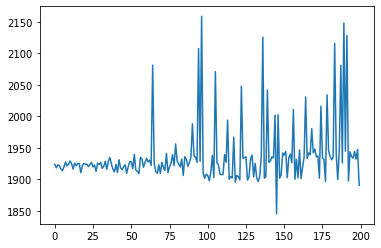

In [15]:
plt.plot(rewards_storage)

In [17]:
df_main=pd.read_csv('D:\RL PROJECT\mountain_car\main_algo_rwards_15_06.csv')
df_main

,Unnamed: 0,0
0,0,1921.078817
1,1,1925.824245
2,2,1918.720077
3,3,1921.233167
4,4,1918.337112
...,...,...
204,204,1954.338859
205,205,1957.935187
206,206,1957.156565
207,207,1876.974568


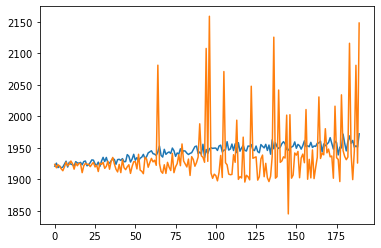

In [20]:
plt.plot(df_main['0'][:190])
plt.plot(rewards_storage[:190])